# Arcfaceのスケーリングの影響をCifar10で確認する。
sが小さいと性能が明らかに低くなった。sが小さい場合に勾配が小さくなることが原因だと考えられる。
- Arcfaceなし
  - tr_loss:28.105159789323807, tr_acc:0.9496794871794871, ts_loss:15.983343750238419, ts_acc:0.8881
- Arcfaceあり, s=1
  - tr_loss:307.3714872598648, tr_acc:0.6357572115384615, ts_loss:64.37207841873169, ts_acc:0.6053
- Arcfaceあり, s=64
  - tr_loss:28.318743254989386, tr_acc:0.9489182692307693, ts_loss:16.825588554143906, ts_acc:0.8813

In [1]:
import json
import math
import os
import random
import sys
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from tqdm import tqdm

In [2]:
def set_seed(seed):
    # python の組み込み関数の seed を固定
    random.seed(seed)
    # torch の seed を固定
    torch.manual_seed(seed)
    # numpy の seed を固定
    np.random.seed(seed)

    # cuDNN が決定的アルゴリズムを使用する
    torch.backends.cudnn.benchmark = False
    # 決定論的アルゴリズムを使用する
    torch.backends.cudnn.deterministic = True


def train_supervised(device, args):
    """
    教師あり学習
    """
    args.checkpoint_dir.mkdir(parents=True, exist_ok=True)
    
    # 乱数シード固定
    set_seed(24)

    # データ
    tr_trans = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    ts_trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    tr_ds = TinyCIFAR10(root='./data', train=True, download=True, transform=tr_trans, use_rate=args.tr_rate)
    tr_dl = torch.utils.data.DataLoader(tr_ds, batch_size=args.batch_size, drop_last=True, num_workers=args.workers, pin_memory=True)

    ts_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=ts_trans)
    ts_dl = torch.utils.data.DataLoader(ts_ds, batch_size=args.batch_size, num_workers=args.workers, pin_memory=True)

    # モデル
    model = ArcfaceResNet('resnet18', dict(zero_init_residual=True), args.arcface_s)
    model.to(device)

    # criterion, optimizer
    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # train
    results = {'epoch':[], 'tr_loss':[], 'tr_acc':[], 'ts_loss':[], 'ts_acc':[], }
    for epoch in range(args.epochs):
        print(f'Epoch {epoch}')
        tr_loss, tr_acc = run_epoch(True, device, model, tr_dl, opt, criterion)
        ts_loss, ts_acc = run_epoch(False, device, model, ts_dl, None, criterion)
        print(f'tr_loss:{tr_loss}, tr_acc:{tr_acc}, ts_loss:{ts_loss}, ts_acc:{ts_acc}')

        results['epoch'].append(epoch)
        results['tr_loss'].append(tr_loss)
        results['tr_acc'].append(tr_acc)
        results['ts_loss'].append(ts_loss)
        results['ts_acc'].append(ts_acc)

    # save
    torch.save(model.state_dict(), args.checkpoint_dir / 'model.pth')
    results = pd.DataFrame.from_dict(results)
    results.to_csv(args.checkpoint_dir / 'results.csv')

    return results


def run_epoch(train, device, model, dl, optimizer, criterion):
    if train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(dl)):
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.set_grad_enabled(train):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        if train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = correct / total

    return total_loss, acc


class ArcfaceWoMargin(nn.Module):
    """
    簡単のためマージンなしのArcface
    """
    def __init__(self, in_features, out_features, s=64):
        super().__init__()
        self.s = s
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.w = self.linear.weight

    def forward(self, x):
        cos = F.linear(F.normalize(x), F.normalize(self.w))
        return cos * self.s


class ArcfaceResNet(nn.Module):
    """
    Cifar10は画像サイズ32x32と小さいので、ResNetの最初の層を変更する。
    https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
    https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
    """
    def __init__(self, model_name, model_kwargs, arcface_s=None):
        """
        Args:
            model_name (str): 'resnet18', 'resnet34',...
            model_kwargs (dict): torchvision.models.resnet**()の引数
        """
        super().__init__()

        if model_name == 'resnet18':
            resnet = torchvision.models.resnet18(**model_kwargs)
        elif model_name == 'resnet34':
            resnet = torchvision.models.resnet34(**model_kwargs)
        elif model_name == 'resnet50':
            resnet = torchvision.models.resnet50(**model_kwargs)
        elif model_name == 'resnet101':
            resnet = torchvision.models.resnet101(**model_kwargs)
        elif model_name == 'resnet152':
            resnet = torchvision.models.resnet152(**model_kwargs)
        else:
            resnet = None

        self.inplanes = 64
        # デフォルトではkernel_size=7だが3にする。
        # デフォルトではstride=2だが1にする。
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # maxpoolingを削除
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool

        if arcface_s is None:
            self.fc = nn.Linear(512, 10)
        else:
            self.fc = ArcfaceWoMargin(512, 10, arcface_s)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


class TinyCIFAR10(torchvision.datasets.CIFAR10):
    """
    データ数を減らしたCifar10
    use_rateでデータ使用率を決める
    """
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, use_rate=0.1):
        super().__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.use_rate = use_rate
        self.n_data = int(super().__len__() * use_rate)
        self.set_tiny_index()

    def set_tiny_index(self):
        """
        TinyCifar10のインデックス設定
        """
        # Cifar10のインデックス
        base_idxs = np.arange(super().__len__())

        # TinyCifar10のインデックス
        # Cifar10のインデックスからn_dataだけランダムチョイスする(重複無し)
        self.tiny_idxs = np.random.choice(base_idxs, size=self.n_data, replace=False)

    def __getitem__(self, index):
        return super().__getitem__(self.tiny_idxs[index])

    def __len__(self):
        return self.n_data


class Args:
    def __init__(self):
        return

In [3]:
def run_supervised(tr_rate=0.5, epochs=10, lr=0.001, arcface_s=None):
    args = Args()
    args.tr_rate = tr_rate
    args.arcface_s = arcface_s

    args.workers = 0
    args.epochs = epochs
    args.batch_size = 256
    args.lr = lr
    args.weight_decay = 5e-4
    args.checkpoint_dir = Path('./result/')
    device = 'cuda'

    rslts = train_supervised(device, args)
    return rslts

# Arcfaceなし

In [4]:
rslts = run_supervised(tr_rate=1.0, epochs=100, lr=0.001, arcface_s=None)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:305.5476539134979, tr_acc:0.4233573717948718, ts_loss:71.08425116539001, ts_acc:0.4289
Epoch 1


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:217.589926302433, tr_acc:0.596875, ts_loss:54.964972615242004, ts_acc:0.5344
Epoch 2


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:180.42973917722702, tr_acc:0.6718950320512821, ts_loss:38.92060649394989, ts_acc:0.6615
Epoch 3


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:153.1741332411766, tr_acc:0.7238581730769231, ts_loss:41.79065239429474, ts_acc:0.6566
Epoch 4


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:132.2425920367241, tr_acc:0.7640224358974359, ts_loss:34.87033054232597, ts_acc:0.7121
Epoch 5


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:117.63825419545174, tr_acc:0.7929487179487179, ts_loss:27.669346868991852, ts_acc:0.7656
Epoch 6


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:106.88614398241043, tr_acc:0.8107972756410257, ts_loss:26.671518474817276, ts_acc:0.777
Epoch 7


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:98.63894239068031, tr_acc:0.825741185897436, ts_loss:29.208758234977722, ts_acc:0.7561
Epoch 8


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:91.49556657671928, tr_acc:0.8388822115384615, ts_loss:23.095352798700333, ts_acc:0.804
Epoch 9


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:85.61988243460655, tr_acc:0.8496394230769231, ts_loss:25.586763620376587, ts_acc:0.7847
Epoch 10


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:80.62562063336372, tr_acc:0.857852564102564, ts_loss:21.880404591560364, ts_acc:0.8179
Epoch 11


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:76.88294696807861, tr_acc:0.8647836538461539, ts_loss:21.690593361854553, ts_acc:0.82
Epoch 12


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:72.69739434123039, tr_acc:0.8731169871794872, ts_loss:21.19100797176361, ts_acc:0.8193
Epoch 13


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:70.21804900467396, tr_acc:0.8770833333333333, ts_loss:20.27244272828102, ts_acc:0.8331
Epoch 14


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:67.24005511403084, tr_acc:0.8830528846153847, ts_loss:20.327460408210754, ts_acc:0.8339
Epoch 15


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:65.41434919834137, tr_acc:0.8848157051282052, ts_loss:20.598277390003204, ts_acc:0.8354
Epoch 16


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:62.50239047408104, tr_acc:0.8903645833333333, ts_loss:20.89383813738823, ts_acc:0.8352
Epoch 17


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:59.30968651175499, tr_acc:0.8943709935897436, ts_loss:20.14376175403595, ts_acc:0.8397
Epoch 18


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:58.80392122268677, tr_acc:0.8971153846153846, ts_loss:17.97115033864975, ts_acc:0.8534
Epoch 19


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:56.96766905486584, tr_acc:0.8999198717948718, ts_loss:18.584097892045975, ts_acc:0.8511
Epoch 20


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:54.39357094466686, tr_acc:0.9045673076923076, ts_loss:20.650664806365967, ts_acc:0.8382
Epoch 21


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:53.921438470482826, tr_acc:0.9055288461538461, ts_loss:18.14742523431778, ts_acc:0.8529
Epoch 22


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:51.97674384713173, tr_acc:0.9079927884615384, ts_loss:19.591399371623993, ts_acc:0.8466
Epoch 23


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:50.48671504855156, tr_acc:0.9115985576923077, ts_loss:17.202456146478653, ts_acc:0.8641
Epoch 24


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:49.647150203585625, tr_acc:0.9133814102564103, ts_loss:20.52008429169655, ts_acc:0.8426
Epoch 25


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:48.86115099489689, tr_acc:0.9129607371794872, ts_loss:17.292060762643814, ts_acc:0.8596
Epoch 26


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:46.957620710134506, tr_acc:0.9166266025641026, ts_loss:18.146078020334244, ts_acc:0.8589
Epoch 27


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:46.65641126036644, tr_acc:0.9176682692307693, ts_loss:16.42364550381899, ts_acc:0.8679
Epoch 28


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:46.13947123289108, tr_acc:0.9169070512820513, ts_loss:18.503150552511215, ts_acc:0.8586
Epoch 29


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:44.15986981987953, tr_acc:0.921113782051282, ts_loss:17.121253728866577, ts_acc:0.87
Epoch 30


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:44.34194378554821, tr_acc:0.9217948717948717, ts_loss:21.0746790766716, ts_acc:0.846
Epoch 31


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:43.57405082881451, tr_acc:0.9229767628205128, ts_loss:15.92981444299221, ts_acc:0.8738
Epoch 32


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:41.92656369507313, tr_acc:0.9266225961538461, ts_loss:17.25342897325754, ts_acc:0.8682
Epoch 33


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:42.51523777842522, tr_acc:0.9243790064102564, ts_loss:14.274359360337257, ts_acc:0.887
Epoch 34


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:41.56504034250975, tr_acc:0.9262019230769231, ts_loss:19.298292011022568, ts_acc:0.8614
Epoch 35


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:40.45501217991114, tr_acc:0.9274839743589743, ts_loss:18.31627106666565, ts_acc:0.8661
Epoch 36


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:39.773191809654236, tr_acc:0.930068108974359, ts_loss:16.44819465279579, ts_acc:0.8727
Epoch 37


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:39.78128471970558, tr_acc:0.9291065705128205, ts_loss:14.861221551895142, ts_acc:0.8825
Epoch 38


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:38.76463736593723, tr_acc:0.9313301282051282, ts_loss:15.65348994731903, ts_acc:0.8776
Epoch 39


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:38.65735062211752, tr_acc:0.9316907051282052, ts_loss:15.048483431339264, ts_acc:0.8833
Epoch 40


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:37.94923660904169, tr_acc:0.9326923076923077, ts_loss:15.383412942290306, ts_acc:0.8762
Epoch 41


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:37.470095470547676, tr_acc:0.9337540064102564, ts_loss:15.110318571329117, ts_acc:0.8828
Epoch 42


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:38.87173253297806, tr_acc:0.93046875, ts_loss:15.342080146074295, ts_acc:0.8838
Epoch 43


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:36.96471419930458, tr_acc:0.9341546474358975, ts_loss:17.26304329931736, ts_acc:0.8687
Epoch 44


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:36.479476392269135, tr_acc:0.9359975961538461, ts_loss:16.55306789278984, ts_acc:0.8777
Epoch 45


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:35.96435762941837, tr_acc:0.9359975961538461, ts_loss:15.519230544567108, ts_acc:0.8802
Epoch 46


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:36.42860559374094, tr_acc:0.9351963141025641, ts_loss:15.657531544566154, ts_acc:0.881
Epoch 47


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:35.00011218339205, tr_acc:0.9377403846153847, ts_loss:17.842058420181274, ts_acc:0.871
Epoch 48


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:34.624883733689785, tr_acc:0.9387820512820513, ts_loss:15.8352340310812, ts_acc:0.877
Epoch 49


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:35.87536305189133, tr_acc:0.9358373397435897, ts_loss:14.405173033475876, ts_acc:0.8874
Epoch 50


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:35.30789965391159, tr_acc:0.9372796474358974, ts_loss:16.096464723348618, ts_acc:0.8796
Epoch 51


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:34.75786258280277, tr_acc:0.9388822115384615, ts_loss:15.03096091747284, ts_acc:0.8868
Epoch 52


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:34.38596882671118, tr_acc:0.9395032051282052, ts_loss:14.657706528902054, ts_acc:0.8894
Epoch 53


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:34.11940471082926, tr_acc:0.9395833333333333, ts_loss:17.687098667025566, ts_acc:0.8733
Epoch 54


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.5727845877409, tr_acc:0.9407051282051282, ts_loss:15.130203768610954, ts_acc:0.8875
Epoch 55


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:34.4348644092679, tr_acc:0.9386618589743589, ts_loss:13.865255653858185, ts_acc:0.8938
Epoch 56


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.017043210566044, tr_acc:0.9424879807692308, ts_loss:18.558199614286423, ts_acc:0.8646
Epoch 57


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.27284947037697, tr_acc:0.9411858974358974, ts_loss:14.40989775210619, ts_acc:0.8903
Epoch 58


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:32.32732043415308, tr_acc:0.9426482371794872, ts_loss:15.784945100545883, ts_acc:0.8829
Epoch 59


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.29164282232523, tr_acc:0.9418269230769231, ts_loss:16.662576600909233, ts_acc:0.8769
Epoch 60


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.870195500552654, tr_acc:0.9442708333333333, ts_loss:17.323851764202118, ts_acc:0.8746
Epoch 61


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:32.38367136567831, tr_acc:0.9425280448717949, ts_loss:16.970296792685986, ts_acc:0.8799
Epoch 62


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.589310869574547, tr_acc:0.9440104166666666, ts_loss:16.315706804394722, ts_acc:0.8788
Epoch 63


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:32.143557608127594, tr_acc:0.9431490384615384, ts_loss:15.073888674378395, ts_acc:0.886
Epoch 64


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:32.46844004839659, tr_acc:0.9420873397435897, ts_loss:15.96883824467659, ts_acc:0.8824
Epoch 65


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:32.162952065467834, tr_acc:0.9429086538461539, ts_loss:15.591324508190155, ts_acc:0.8798
Epoch 66


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.046470120549202, tr_acc:0.9451522435897436, ts_loss:13.784081369638443, ts_acc:0.8966
Epoch 67


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.93889259546995, tr_acc:0.9466145833333334, ts_loss:14.00570496916771, ts_acc:0.8941
Epoch 68


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.498891785740852, tr_acc:0.9439102564102564, ts_loss:14.323714658617973, ts_acc:0.8898
Epoch 69


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.186681278049946, tr_acc:0.9446915064102565, ts_loss:14.938714124262333, ts_acc:0.8859
Epoch 70


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.029199048876762, tr_acc:0.9449118589743589, ts_loss:14.235669270157814, ts_acc:0.8903
Epoch 71


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.408326230943203, tr_acc:0.9454727564102564, ts_loss:16.727153658866882, ts_acc:0.8807
Epoch 72


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.038649909198284, tr_acc:0.944931891025641, ts_loss:13.645530253648758, ts_acc:0.8941
Epoch 73


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.639591559767723, tr_acc:0.9480568910256411, ts_loss:16.053492784500122, ts_acc:0.8812
Epoch 74


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.888592444360256, tr_acc:0.9457932692307692, ts_loss:15.395091861486435, ts_acc:0.8866
Epoch 75


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.414282582700253, tr_acc:0.94765625, ts_loss:15.919219344854355, ts_acc:0.885
Epoch 76


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.512127161026, tr_acc:0.9465945512820513, ts_loss:15.177475243806839, ts_acc:0.8889
Epoch 77


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.41452883183956, tr_acc:0.9494791666666667, ts_loss:15.88945347070694, ts_acc:0.8863
Epoch 78


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.17719817906618, tr_acc:0.9476161858974359, ts_loss:15.469753444194794, ts_acc:0.8815
Epoch 79


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.988973066210747, tr_acc:0.9482972756410256, ts_loss:16.0346961915493, ts_acc:0.881
Epoch 80


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.531028851866722, tr_acc:0.947275641025641, ts_loss:16.371271327137947, ts_acc:0.8834
Epoch 81


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.06113312393427, tr_acc:0.9465745192307692, ts_loss:17.66560995578766, ts_acc:0.8723
Epoch 82


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.2187524959445, tr_acc:0.9457932692307692, ts_loss:16.40622442960739, ts_acc:0.8835
Epoch 83


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:27.866404086351395, tr_acc:0.9509415064102564, ts_loss:15.184592515230179, ts_acc:0.8876
Epoch 84


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.531772390007973, tr_acc:0.948076923076923, ts_loss:15.225163415074348, ts_acc:0.8883
Epoch 85


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.692912958562374, tr_acc:0.9504407051282051, ts_loss:16.635231107473373, ts_acc:0.8814
Epoch 86


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.723172526806593, tr_acc:0.9471554487179488, ts_loss:15.760464906692505, ts_acc:0.8856
Epoch 87


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.114025063812733, tr_acc:0.948036858974359, ts_loss:16.857802510261536, ts_acc:0.8812
Epoch 88


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.235930506139994, tr_acc:0.9500600961538461, ts_loss:16.381241470575333, ts_acc:0.8906
Epoch 89


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.589614003896713, tr_acc:0.9497996794871795, ts_loss:17.16907700896263, ts_acc:0.8812
Epoch 90


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.084885329008102, tr_acc:0.9479967948717949, ts_loss:15.499214217066765, ts_acc:0.8875
Epoch 91


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.454469703137875, tr_acc:0.9474759615384616, ts_loss:14.828185454010963, ts_acc:0.8899
Epoch 92


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:27.641848877072334, tr_acc:0.9506209935897436, ts_loss:15.610441386699677, ts_acc:0.8872
Epoch 93


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.276366733014584, tr_acc:0.9502403846153846, ts_loss:16.642423778772354, ts_acc:0.8834
Epoch 94


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:27.62674419209361, tr_acc:0.9517828525641026, ts_loss:14.408358290791512, ts_acc:0.8946
Epoch 95


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:27.676625549793243, tr_acc:0.9505608974358974, ts_loss:14.643290847539902, ts_acc:0.8922
Epoch 96


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.88493985682726, tr_acc:0.948417467948718, ts_loss:14.697989642620087, ts_acc:0.8941
Epoch 97


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.095816180109978, tr_acc:0.9491586538461538, ts_loss:15.990524560213089, ts_acc:0.8855
Epoch 98


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:27.515638880431652, tr_acc:0.9508613782051282, ts_loss:15.112227857112885, ts_acc:0.8905
Epoch 99


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


tr_loss:28.105159789323807, tr_acc:0.9496794871794871, ts_loss:15.983343750238419, ts_acc:0.8881


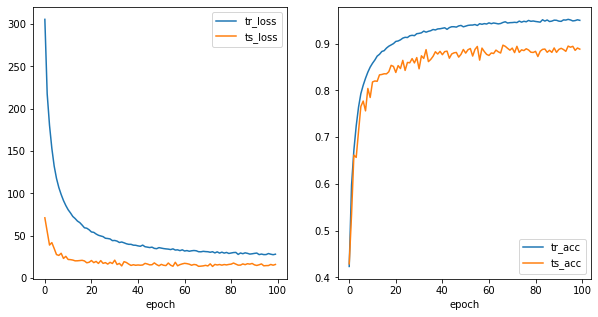

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
rslts.plot(x='epoch', y=['tr_loss', 'ts_loss'], ax=axes[0])
rslts.plot(x='epoch', y=['tr_acc', 'ts_acc'], ax=axes[1])
plt.show()

# Arcface s=1

In [6]:
rslts = run_supervised(tr_rate=1.0, epochs=100, lr=0.001, arcface_s=1)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:388.21537840366364, tr_acc:0.3139423076923077, ts_loss:77.00905549526215, ts_acc:0.354
Epoch 1


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:359.6710294485092, tr_acc:0.41185897435897434, ts_loss:73.13654887676239, ts_acc:0.4238
Epoch 2


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:351.1681332588196, tr_acc:0.446474358974359, ts_loss:74.41533100605011, ts_acc:0.3951
Epoch 3


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:346.87962234020233, tr_acc:0.465224358974359, ts_loss:71.33641958236694, ts_acc:0.4651
Epoch 4


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:342.88070273399353, tr_acc:0.4796073717948718, ts_loss:71.19890534877777, ts_acc:0.4646
Epoch 5


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:340.5381759405136, tr_acc:0.49092548076923076, ts_loss:72.53846001625061, ts_acc:0.4322
Epoch 6


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:337.7774260044098, tr_acc:0.5049278846153846, ts_loss:69.72471332550049, ts_acc:0.4995
Epoch 7


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:334.29737162590027, tr_acc:0.5274439102564102, ts_loss:69.13534986972809, ts_acc:0.5127
Epoch 8


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:331.7774660587311, tr_acc:0.5417467948717949, ts_loss:68.49011194705963, ts_acc:0.5433
Epoch 9


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:329.1833564043045, tr_acc:0.5560296474358974, ts_loss:68.80531919002533, ts_acc:0.5362
Epoch 10


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:327.8008872270584, tr_acc:0.5572115384615385, ts_loss:67.54092872142792, ts_acc:0.5593
Epoch 11


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:325.63176357746124, tr_acc:0.5678685897435898, ts_loss:67.97371709346771, ts_acc:0.5479
Epoch 12


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:324.382697224617, tr_acc:0.5740384615384615, ts_loss:68.32921540737152, ts_acc:0.5407
Epoch 13


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:323.5738545656204, tr_acc:0.5758613782051282, ts_loss:66.97940683364868, ts_acc:0.5813
Epoch 14


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:322.7627693414688, tr_acc:0.5797876602564103, ts_loss:66.84528625011444, ts_acc:0.5607
Epoch 15


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:321.0029561519623, tr_acc:0.5846955128205128, ts_loss:66.9994467496872, ts_acc:0.5682
Epoch 16


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:320.48510015010834, tr_acc:0.58515625, ts_loss:66.88411903381348, ts_acc:0.5628
Epoch 17


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:319.8646150827408, tr_acc:0.5891626602564103, ts_loss:67.01043343544006, ts_acc:0.5554
Epoch 18


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:319.1004709005356, tr_acc:0.5927684294871794, ts_loss:67.65340960025787, ts_acc:0.5281
Epoch 19


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:318.7533391714096, tr_acc:0.5933894230769231, ts_loss:66.1540834903717, ts_acc:0.5809
Epoch 20


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:317.8330934047699, tr_acc:0.5976362179487179, ts_loss:65.82599210739136, ts_acc:0.5703
Epoch 21


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:317.79385340213776, tr_acc:0.598457532051282, ts_loss:67.51629912853241, ts_acc:0.5659
Epoch 22


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:316.7369941473007, tr_acc:0.6007211538461539, ts_loss:66.84619438648224, ts_acc:0.5501
Epoch 23


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:315.9908196926117, tr_acc:0.6032251602564103, ts_loss:65.98141920566559, ts_acc:0.5754
Epoch 24


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:315.7910690307617, tr_acc:0.6043669871794872, ts_loss:64.90926253795624, ts_acc:0.5945
Epoch 25


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:315.5832620859146, tr_acc:0.6061498397435897, ts_loss:65.09544384479523, ts_acc:0.5958
Epoch 26


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:315.3931360244751, tr_acc:0.6092347756410257, ts_loss:66.53749811649323, ts_acc:0.5595
Epoch 27


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:315.22050964832306, tr_acc:0.6081730769230769, ts_loss:65.33500361442566, ts_acc:0.5841
Epoch 28


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:314.60669672489166, tr_acc:0.6084535256410256, ts_loss:65.44799268245697, ts_acc:0.5999
Epoch 29


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:314.67093098163605, tr_acc:0.6095352564102564, ts_loss:65.4987280368805, ts_acc:0.5961
Epoch 30


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:314.0833572149277, tr_acc:0.6100961538461539, ts_loss:65.63680219650269, ts_acc:0.5745
Epoch 31


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:313.6854245662689, tr_acc:0.6135817307692307, ts_loss:65.17682456970215, ts_acc:0.6015
Epoch 32


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:313.8311080932617, tr_acc:0.6129206730769231, ts_loss:64.74178886413574, ts_acc:0.6021
Epoch 33


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:312.9456810951233, tr_acc:0.6151241987179488, ts_loss:65.24027013778687, ts_acc:0.582
Epoch 34


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:313.2405027151108, tr_acc:0.6134815705128205, ts_loss:65.14296591281891, ts_acc:0.5913
Epoch 35


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:312.42515754699707, tr_acc:0.616426282051282, ts_loss:65.86704099178314, ts_acc:0.5673
Epoch 36


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:312.62191450595856, tr_acc:0.61640625, ts_loss:65.82884645462036, ts_acc:0.5848
Epoch 37


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:312.6017323732376, tr_acc:0.6176282051282052, ts_loss:64.60859310626984, ts_acc:0.6102
Epoch 38


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.84250497817993, tr_acc:0.6205128205128205, ts_loss:65.06932830810547, ts_acc:0.586
Epoch 39


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.70681619644165, tr_acc:0.6193309294871795, ts_loss:65.03361141681671, ts_acc:0.5903
Epoch 40


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.51006972789764, tr_acc:0.6202123397435897, ts_loss:65.07663333415985, ts_acc:0.5825
Epoch 41


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.4479566812515, tr_acc:0.6206330128205129, ts_loss:65.10879325866699, ts_acc:0.5866
Epoch 42


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.6416471004486, tr_acc:0.6196314102564102, ts_loss:64.47488701343536, ts_acc:0.6031
Epoch 43


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.2940055131912, tr_acc:0.6201722756410256, ts_loss:64.56047439575195, ts_acc:0.6046
Epoch 44


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.69732654094696, tr_acc:0.6183894230769231, ts_loss:64.82983565330505, ts_acc:0.5896
Epoch 45


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.086661696434, tr_acc:0.6216947115384616, ts_loss:65.01157116889954, ts_acc:0.5969
Epoch 46


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.5539445877075, tr_acc:0.621875, ts_loss:64.61957859992981, ts_acc:0.5984
Epoch 47


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.22573125362396, tr_acc:0.6227764423076924, ts_loss:65.37006449699402, ts_acc:0.5884
Epoch 48


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:311.4412884712219, tr_acc:0.6199919871794872, ts_loss:64.13409078121185, ts_acc:0.6104
Epoch 49


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.85121405124664, tr_acc:0.6239383012820513, ts_loss:64.64521515369415, ts_acc:0.5921
Epoch 50


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.6479163169861, tr_acc:0.6246794871794872, ts_loss:64.83437383174896, ts_acc:0.5977
Epoch 51


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.2448546886444, tr_acc:0.6240584935897436, ts_loss:64.87888813018799, ts_acc:0.5973
Epoch 52


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.9845234155655, tr_acc:0.6238381410256411, ts_loss:64.70620334148407, ts_acc:0.597
Epoch 53


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.2481426000595, tr_acc:0.625, ts_loss:64.50456619262695, ts_acc:0.6027
Epoch 54


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.6727577447891, tr_acc:0.622676282051282, ts_loss:65.03815424442291, ts_acc:0.5903
Epoch 55


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.6849364042282, tr_acc:0.6244991987179487, ts_loss:67.26917064189911, ts_acc:0.56
Epoch 56


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.41606509685516, tr_acc:0.623858173076923, ts_loss:64.45143485069275, ts_acc:0.606
Epoch 57


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.29472148418427, tr_acc:0.6263221153846154, ts_loss:64.46477258205414, ts_acc:0.6043
Epoch 58


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.79086887836456, tr_acc:0.626522435897436, ts_loss:64.69846987724304, ts_acc:0.6021
Epoch 59


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.10965383052826, tr_acc:0.6252604166666667, ts_loss:64.38515090942383, ts_acc:0.6087
Epoch 60


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.0886090993881, tr_acc:0.6270633012820512, ts_loss:65.1620078086853, ts_acc:0.5909
Epoch 61


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.7206172943115, tr_acc:0.6255608974358975, ts_loss:64.72157120704651, ts_acc:0.5981
Epoch 62


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.38954043388367, tr_acc:0.6297876602564103, ts_loss:64.59481918811798, ts_acc:0.5974
Epoch 63


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:310.2138925790787, tr_acc:0.6250801282051283, ts_loss:64.44679892063141, ts_acc:0.6037
Epoch 64


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.40210354328156, tr_acc:0.6270432692307693, ts_loss:64.55650687217712, ts_acc:0.5976
Epoch 65


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.30545115470886, tr_acc:0.6295873397435897, ts_loss:64.23071348667145, ts_acc:0.6114
Epoch 66


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.23921394348145, tr_acc:0.6307491987179488, ts_loss:64.28273177146912, ts_acc:0.6034
Epoch 67


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.4880133867264, tr_acc:0.6275841346153846, ts_loss:64.69759225845337, ts_acc:0.5961
Epoch 68


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.4842576980591, tr_acc:0.6274439102564102, ts_loss:64.85236072540283, ts_acc:0.5969
Epoch 69


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.2268327474594, tr_acc:0.6292467948717949, ts_loss:64.27301180362701, ts_acc:0.6093
Epoch 70


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.9617518186569, tr_acc:0.6267628205128205, ts_loss:65.22681653499603, ts_acc:0.593
Epoch 71


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.82775819301605, tr_acc:0.6303685897435898, ts_loss:64.14054536819458, ts_acc:0.6067
Epoch 72


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.8688288927078, tr_acc:0.6300681089743589, ts_loss:64.25012946128845, ts_acc:0.6129
Epoch 73


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.62387204170227, tr_acc:0.626141826923077, ts_loss:64.18793773651123, ts_acc:0.6089
Epoch 74


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:309.20468866825104, tr_acc:0.6285456730769231, ts_loss:63.8725700378418, ts_acc:0.6133
Epoch 75


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.6356943845749, tr_acc:0.6331530448717949, ts_loss:64.15721714496613, ts_acc:0.6126
Epoch 76


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.25301027297974, tr_acc:0.6321314102564103, ts_loss:63.9921133518219, ts_acc:0.6144
Epoch 77


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.69551944732666, tr_acc:0.6317508012820513, ts_loss:64.02515840530396, ts_acc:0.6087
Epoch 78


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.8249125480652, tr_acc:0.6301482371794872, ts_loss:64.94014525413513, ts_acc:0.5941
Epoch 79


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.98940336704254, tr_acc:0.6335136217948718, ts_loss:63.925172328948975, ts_acc:0.6134
Epoch 80


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.5342743396759, tr_acc:0.6315705128205128, ts_loss:64.01940083503723, ts_acc:0.6158
Epoch 81


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.66080391407013, tr_acc:0.6311498397435897, ts_loss:64.14062011241913, ts_acc:0.6128
Epoch 82


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.65294194221497, tr_acc:0.6325921474358974, ts_loss:64.50727081298828, ts_acc:0.6077
Epoch 83


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.323601603508, tr_acc:0.6322516025641025, ts_loss:63.73558008670807, ts_acc:0.6207
Epoch 84


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.09900081157684, tr_acc:0.6308894230769231, ts_loss:63.94009983539581, ts_acc:0.6154
Epoch 85


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.5126554965973, tr_acc:0.6326923076923077, ts_loss:64.70317947864532, ts_acc:0.5953
Epoch 86


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.7147536277771, tr_acc:0.630849358974359, ts_loss:64.9920289516449, ts_acc:0.5846
Epoch 87


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.7958656549454, tr_acc:0.6334735576923077, ts_loss:64.28369975090027, ts_acc:0.6109
Epoch 88


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.22835779190063, tr_acc:0.6332532051282052, ts_loss:64.41165053844452, ts_acc:0.6044
Epoch 89


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.82908594608307, tr_acc:0.6337740384615385, ts_loss:64.10065710544586, ts_acc:0.6137
Epoch 90


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.7640805244446, tr_acc:0.6346955128205128, ts_loss:64.01254880428314, ts_acc:0.6144
Epoch 91


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.21010184288025, tr_acc:0.6333533653846154, ts_loss:63.67928946018219, ts_acc:0.6148
Epoch 92


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.7814942598343, tr_acc:0.6338341346153846, ts_loss:63.903130888938904, ts_acc:0.611
Epoch 93


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.2920117378235, tr_acc:0.6366786858974359, ts_loss:63.98234987258911, ts_acc:0.6153
Epoch 94


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.8385989665985, tr_acc:0.6333533653846154, ts_loss:63.9999235868454, ts_acc:0.6184
Epoch 95


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:308.0591939687729, tr_acc:0.6344150641025641, ts_loss:64.04136025905609, ts_acc:0.6128
Epoch 96


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.5489376783371, tr_acc:0.6348958333333333, ts_loss:64.2938883304596, ts_acc:0.6126
Epoch 97


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.9908057451248, tr_acc:0.6347956730769231, ts_loss:64.22285270690918, ts_acc:0.6136
Epoch 98


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:307.61717092990875, tr_acc:0.6359775641025641, ts_loss:64.18830370903015, ts_acc:0.6133
Epoch 99


100%|██████████| 40/40 [00:04<00:00,  9.41it/s]


tr_loss:307.3714872598648, tr_acc:0.6357572115384615, ts_loss:64.37207841873169, ts_acc:0.6053


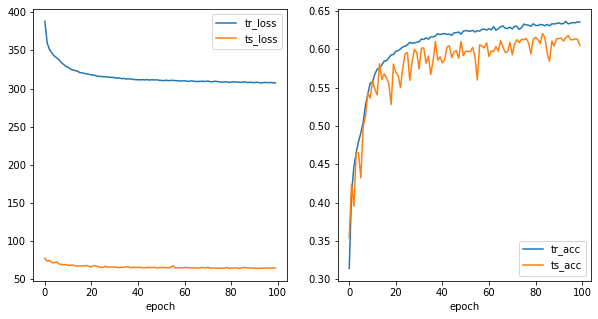

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
rslts.plot(x='epoch', y=['tr_loss', 'ts_loss'], ax=axes[0])
rslts.plot(x='epoch', y=['tr_acc', 'ts_acc'], ax=axes[1])
plt.show()

# Arcface s=64

In [8]:
rslts = run_supervised(tr_rate=1.0, epochs=100, lr=0.001, arcface_s=64)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:349.66634130477905, tr_acc:0.3625, ts_loss:62.66267919540405, ts_acc:0.442
Epoch 1


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:270.42953753471375, tr_acc:0.5002604166666667, ts_loss:53.89960813522339, ts_acc:0.5284
Epoch 2


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:231.26420271396637, tr_acc:0.5765224358974359, ts_loss:47.37384629249573, ts_acc:0.5882
Epoch 3


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:200.77866286039352, tr_acc:0.6324919871794872, ts_loss:43.88918036222458, ts_acc:0.6356
Epoch 4


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:175.6684007048607, tr_acc:0.6810897435897436, ts_loss:38.05719459056854, ts_acc:0.6779
Epoch 5


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:153.78269970417023, tr_acc:0.724238782051282, ts_loss:34.43540096282959, ts_acc:0.7111
Epoch 6


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:137.41355633735657, tr_acc:0.7549879807692308, ts_loss:32.313274681568146, ts_acc:0.7325
Epoch 7


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:125.38799431920052, tr_acc:0.7783653846153846, ts_loss:29.103600084781647, ts_acc:0.7552
Epoch 8


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:115.28546398878098, tr_acc:0.7952724358974359, ts_loss:30.823629021644592, ts_acc:0.75
Epoch 9


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:107.48583251237869, tr_acc:0.8102163461538462, ts_loss:31.34648036956787, ts_acc:0.7525
Epoch 10


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:100.42932477593422, tr_acc:0.8220352564102564, ts_loss:26.708096861839294, ts_acc:0.7823
Epoch 11


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:94.78612658381462, tr_acc:0.8326121794871795, ts_loss:28.119155168533325, ts_acc:0.7785
Epoch 12


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:89.74510586261749, tr_acc:0.8410456730769231, ts_loss:36.61563915014267, ts_acc:0.738
Epoch 13


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:86.58674049377441, tr_acc:0.8475560897435898, ts_loss:26.495361626148224, ts_acc:0.7942
Epoch 14


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:82.11451591551304, tr_acc:0.854326923076923, ts_loss:24.79993462562561, ts_acc:0.8036
Epoch 15


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:78.76488041877747, tr_acc:0.8598157051282052, ts_loss:23.22176879644394, ts_acc:0.8203
Epoch 16


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:76.2315039485693, tr_acc:0.8654647435897436, ts_loss:22.13318905234337, ts_acc:0.8284
Epoch 17


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:72.80858494341373, tr_acc:0.8713942307692307, ts_loss:20.85465905070305, ts_acc:0.8364
Epoch 18


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:69.87125863134861, tr_acc:0.8754607371794871, ts_loss:21.66846853494644, ts_acc:0.8326
Epoch 19


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:66.93190707266331, tr_acc:0.8805689102564103, ts_loss:24.774783939123154, ts_acc:0.8149
Epoch 20


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:65.2711089104414, tr_acc:0.883613782051282, ts_loss:20.421649307012558, ts_acc:0.8391
Epoch 21


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:62.976817816495895, tr_acc:0.888301282051282, ts_loss:21.275919675827026, ts_acc:0.8389
Epoch 22


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:62.016314789652824, tr_acc:0.8901442307692308, ts_loss:19.048931121826172, ts_acc:0.8485
Epoch 23


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:59.74433936178684, tr_acc:0.8938301282051282, ts_loss:21.550357908010483, ts_acc:0.842
Epoch 24


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:57.58550325036049, tr_acc:0.8982572115384615, ts_loss:23.57071653008461, ts_acc:0.8293
Epoch 25


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:56.78442704677582, tr_acc:0.8977363782051282, ts_loss:21.588492661714554, ts_acc:0.8491
Epoch 26


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:54.12930662930012, tr_acc:0.9038261217948718, ts_loss:19.00510945916176, ts_acc:0.8588
Epoch 27


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:53.250353276729584, tr_acc:0.9062700320512821, ts_loss:20.425771862268448, ts_acc:0.8528
Epoch 28


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:52.41700819134712, tr_acc:0.9064102564102564, ts_loss:17.994588300585747, ts_acc:0.8603
Epoch 29


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:51.53161017596722, tr_acc:0.9083934294871795, ts_loss:18.14018315076828, ts_acc:0.8559
Epoch 30


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:49.663487166166306, tr_acc:0.9108573717948718, ts_loss:16.80849838256836, ts_acc:0.8707
Epoch 31


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:48.93909867107868, tr_acc:0.9125600961538461, ts_loss:17.96469682455063, ts_acc:0.8681
Epoch 32


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:48.41454221308231, tr_acc:0.9136017628205129, ts_loss:19.36942031979561, ts_acc:0.8611
Epoch 33


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:46.44548511505127, tr_acc:0.9172275641025641, ts_loss:16.7150177359581, ts_acc:0.8745
Epoch 34


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:45.19379252195358, tr_acc:0.9207932692307692, ts_loss:17.94136044383049, ts_acc:0.8667
Epoch 35


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:44.56920512020588, tr_acc:0.9209334935897436, ts_loss:18.18222016096115, ts_acc:0.862
Epoch 36


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:43.48297320306301, tr_acc:0.9218149038461538, ts_loss:16.41015249490738, ts_acc:0.8777
Epoch 37


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:42.78673067688942, tr_acc:0.9220953525641026, ts_loss:19.58010098338127, ts_acc:0.8611
Epoch 38


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:43.83672411739826, tr_acc:0.9212339743589744, ts_loss:17.539210855960846, ts_acc:0.8694
Epoch 39


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:41.49336229264736, tr_acc:0.9254807692307693, ts_loss:18.6691754758358, ts_acc:0.8681
Epoch 40


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:41.60037983208895, tr_acc:0.9242788461538461, ts_loss:17.891131788492203, ts_acc:0.871
Epoch 41


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:40.20986799150705, tr_acc:0.9279647435897436, ts_loss:17.670743376016617, ts_acc:0.8736
Epoch 42


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:39.885294280946255, tr_acc:0.9268830128205128, ts_loss:16.508144289255142, ts_acc:0.8809
Epoch 43


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:38.95220020413399, tr_acc:0.9303886217948718, ts_loss:16.001462399959564, ts_acc:0.8803
Epoch 44


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:38.72184623032808, tr_acc:0.9305889423076923, ts_loss:19.36866667866707, ts_acc:0.8611
Epoch 45


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:38.53462851792574, tr_acc:0.9304286858974359, ts_loss:16.894987285137177, ts_acc:0.8756
Epoch 46


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:38.761819534003735, tr_acc:0.9292267628205129, ts_loss:15.145572066307068, ts_acc:0.8853
Epoch 47


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:37.75180768966675, tr_acc:0.931630608974359, ts_loss:16.806547790765762, ts_acc:0.8781
Epoch 48


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:38.23228166252375, tr_acc:0.9307291666666667, ts_loss:19.347709983587265, ts_acc:0.869
Epoch 49


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:37.444508105516434, tr_acc:0.9313100961538462, ts_loss:18.24548664689064, ts_acc:0.873
Epoch 50


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:36.33395989239216, tr_acc:0.9345753205128206, ts_loss:17.451305389404297, ts_acc:0.8756
Epoch 51


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:35.31888757646084, tr_acc:0.9365985576923077, ts_loss:19.238194525241852, ts_acc:0.8612
Epoch 52


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:36.5919988155365, tr_acc:0.9334935897435898, ts_loss:17.774133265018463, ts_acc:0.8714
Epoch 53


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:35.25291255861521, tr_acc:0.9350560897435898, ts_loss:18.021031707525253, ts_acc:0.8756
Epoch 54


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:35.72174995392561, tr_acc:0.9342948717948718, ts_loss:18.070448398590088, ts_acc:0.875
Epoch 55


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:35.52644843608141, tr_acc:0.9361979166666666, ts_loss:17.481425493955612, ts_acc:0.8761
Epoch 56


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:34.15429323911667, tr_acc:0.938301282051282, ts_loss:20.890493869781494, ts_acc:0.8644
Epoch 57


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:34.58642948418856, tr_acc:0.9381610576923077, ts_loss:19.954814970493317, ts_acc:0.8618
Epoch 58


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:34.66139664500952, tr_acc:0.9366586538461539, ts_loss:16.985831260681152, ts_acc:0.875
Epoch 59


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:34.023681692779064, tr_acc:0.9383613782051282, ts_loss:16.750925332307816, ts_acc:0.8797
Epoch 60


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.952438957989216, tr_acc:0.9386618589743589, ts_loss:17.02956096827984, ts_acc:0.8769
Epoch 61


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.073144890367985, tr_acc:0.9395232371794872, ts_loss:20.73056223988533, ts_acc:0.8659
Epoch 62


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.156517051160336, tr_acc:0.9397035256410257, ts_loss:17.263339310884476, ts_acc:0.8804
Epoch 63


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.94881286472082, tr_acc:0.9380408653846154, ts_loss:15.83281460404396, ts_acc:0.8862
Epoch 64


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:32.619569167494774, tr_acc:0.9412259615384615, ts_loss:17.480002969503403, ts_acc:0.8744
Epoch 65


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.619588911533356, tr_acc:0.939463141025641, ts_loss:18.180855587124825, ts_acc:0.8724
Epoch 66


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:32.297784239053726, tr_acc:0.9415064102564102, ts_loss:17.707287967205048, ts_acc:0.8769
Epoch 67


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:33.06077330559492, tr_acc:0.9401041666666666, ts_loss:15.818649530410767, ts_acc:0.8823
Epoch 68


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:32.188892006874084, tr_acc:0.941025641025641, ts_loss:17.534121870994568, ts_acc:0.8754
Epoch 69


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:32.32589679211378, tr_acc:0.9413661858974359, ts_loss:17.022915974259377, ts_acc:0.8754
Epoch 70


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.652086585760117, tr_acc:0.942167467948718, ts_loss:16.56990897655487, ts_acc:0.881
Epoch 71


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.096445009112358, tr_acc:0.943369391025641, ts_loss:15.35102891921997, ts_acc:0.886
Epoch 72


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.140071906149387, tr_acc:0.9435496794871795, ts_loss:15.343212693929672, ts_acc:0.8851
Epoch 73


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.91305210441351, tr_acc:0.9436698717948718, ts_loss:18.275474905967712, ts_acc:0.8753
Epoch 74


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.22718657553196, tr_acc:0.9440905448717949, ts_loss:17.181724578142166, ts_acc:0.8728
Epoch 75


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.147372156381607, tr_acc:0.9438100961538461, ts_loss:17.13708648085594, ts_acc:0.8763
Epoch 76


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.009316943585873, tr_acc:0.9427083333333334, ts_loss:18.265463531017303, ts_acc:0.867
Epoch 77


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:31.166034899652004, tr_acc:0.942928685897436, ts_loss:17.822409719228745, ts_acc:0.8771
Epoch 78


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.6387158036232, tr_acc:0.9450120192307693, ts_loss:17.816274046897888, ts_acc:0.8772
Epoch 79


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.73767800629139, tr_acc:0.9433894230769231, ts_loss:18.37503883242607, ts_acc:0.8745
Epoch 80


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.288890071213245, tr_acc:0.9448717948717948, ts_loss:17.833539366722107, ts_acc:0.8754
Epoch 81


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.584938496351242, tr_acc:0.9435296474358974, ts_loss:17.401956260204315, ts_acc:0.8781
Epoch 82


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.948272973299026, tr_acc:0.9459134615384616, ts_loss:16.07626035809517, ts_acc:0.8806
Epoch 83


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.406958363950253, tr_acc:0.9461538461538461, ts_loss:17.79014852643013, ts_acc:0.8729
Epoch 84


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:30.051945626735687, tr_acc:0.9463541666666667, ts_loss:17.55024191737175, ts_acc:0.8743
Epoch 85


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.272908344864845, tr_acc:0.9463942307692308, ts_loss:17.925520539283752, ts_acc:0.8726
Epoch 86


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.69285660237074, tr_acc:0.9461538461538461, ts_loss:16.39999532699585, ts_acc:0.8825
Epoch 87


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.81638715416193, tr_acc:0.9459134615384616, ts_loss:16.05889728665352, ts_acc:0.884
Epoch 88


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.410456024110317, tr_acc:0.9466947115384615, ts_loss:16.547156870365143, ts_acc:0.8826
Epoch 89


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.005595549941063, tr_acc:0.9469350961538462, ts_loss:16.813434556126595, ts_acc:0.8832
Epoch 90


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.631578125059605, tr_acc:0.9461738782051282, ts_loss:15.846999511122704, ts_acc:0.8856
Epoch 91


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.07072915136814, tr_acc:0.9469751602564103, ts_loss:15.52956959605217, ts_acc:0.886
Epoch 92


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.04130320996046, tr_acc:0.9483974358974359, ts_loss:17.769255191087723, ts_acc:0.8763
Epoch 93


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.66061457246542, tr_acc:0.9467948717948718, ts_loss:17.14451426267624, ts_acc:0.8766
Epoch 94


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.531265765428543, tr_acc:0.9465144230769231, ts_loss:18.574553966522217, ts_acc:0.8696
Epoch 95


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:29.306665487587452, tr_acc:0.9470753205128205, ts_loss:19.68466418981552, ts_acc:0.8634
Epoch 96


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.467890083789825, tr_acc:0.9474559294871795, ts_loss:15.651849925518036, ts_acc:0.8859
Epoch 97


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.075716763734818, tr_acc:0.9492588141025641, ts_loss:17.141445010900497, ts_acc:0.8774
Epoch 98


  0%|          | 0/195 [00:00<?, ?it/s]

tr_loss:28.46062484756112, tr_acc:0.9483974358974359, ts_loss:16.92299871146679, ts_acc:0.8804
Epoch 99


100%|██████████| 40/40 [00:04<00:00,  9.24it/s]


tr_loss:28.318743254989386, tr_acc:0.9489182692307693, ts_loss:16.825588554143906, ts_acc:0.8813


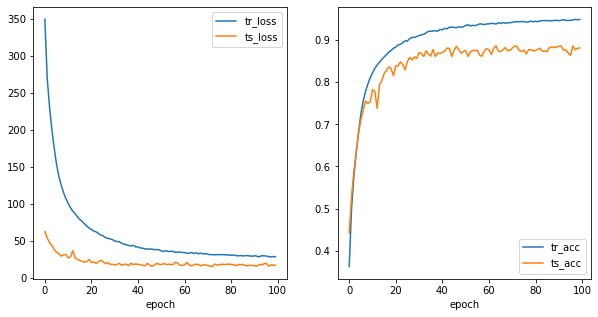

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
rslts.plot(x='epoch', y=['tr_loss', 'ts_loss'], ax=axes[0])
rslts.plot(x='epoch', y=['tr_acc', 'ts_acc'], ax=axes[1])
plt.show()